In [2]:
import xarray as xr
import numpy as np



In [3]:
# open grid file, prepare it by assigning coordiantes of lon2d, lat2d aka x and y 
grid = xr.open_dataset("/Users/james/Downloads/gridFile.nc")
grid  = grid.assign_coords({"lon" : (("y", "x"), grid.x.values)})
grid  = grid.assign_coords({"lat" : (("y", "x"), grid.y.values)})

grid

<xarray.Dataset>
Dimensions:   (nx: 40, nxp: 41, ny: 60, nyp: 61, x: 41, y: 61)
Coordinates:
    x         (nyp, nxp) float64 -131.0 -130.5 -130.1 ... -129.8 -129.1 -128.3
    y         (nyp, nxp) float64 22.06 22.31 22.56 22.81 ... 57.44 57.69 57.93
    lon       (y, x) float64 -131.0 -130.5 -130.1 ... -129.8 -129.1 -128.3
    lat       (y, x) float64 22.06 22.31 22.56 22.81 ... 57.19 57.44 57.69 57.93
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    angle_dx  (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  GridTools: 0.1
    history:       2021-05-05 12:54:49: created grid with GridTools library
    projection:    LambertConformalConic
    proj:          +ellps=GRS80 +proj=lcc +lon_0=230.0 +lat_0=40.0 +x_0=0.0 +...

In [6]:

gebco = xr.open_dataset("/Users/james/Downloads/gebco_2020_netcdf/GEBCO_2020.nc").sel(lat=slice(np.min(grid.y.values), np.max(grid.y.values)), lon=slice(np.min(grid.x.values), np.max(grid.x.values)))
gebco = gebco.coarsen(lon=10,lat=10, boundary='pad').mean()

gebco

<xarray.Dataset>
Dimensions:    (lat: 861, lon: 1004)
Coordinates:
  * lon        (lon) float64 -153.3 -153.2 -153.2 ... -111.5 -111.5 -111.5
  * lat        (lat) float64 22.07 22.12 22.16 22.2 ... 57.78 57.83 57.87 57.91
Data variables:
    elevation  (lat, lon) float32 -4.939e+03 -5.306e+03 ... 258.6 246.1

In [7]:

gebco = gebco.rename({'lon': 'x', 'lat': 'y'})

# get 2D versions of the lat and lon variables (note the -180 here!)
lon2d, lat2d = np.meshgrid(gebco.x.values, gebco.y.values)

#da.assign_coords({"lon_2": ("lon", lon_2)})
gebco = gebco.assign_coords({"lon" : (("y", "x"), lon2d)})
gebco = gebco.assign_coords({"lat" : (("y", "x"), lat2d)})
gebco

<xarray.Dataset>
Dimensions:    (x: 1004, y: 861)
Coordinates:
  * x          (x) float64 -153.3 -153.2 -153.2 -153.1 ... -111.5 -111.5 -111.5
  * y          (y) float64 22.07 22.12 22.16 22.2 ... 57.78 57.83 57.87 57.91
    lon        (y, x) float64 -153.3 -153.2 -153.2 ... -111.5 -111.5 -111.5
    lat        (y, x) float64 22.07 22.07 22.07 22.07 ... 57.91 57.91 57.91
Data variables:
    elevation  (y, x) float32 -4.939e+03 -5.306e+03 -5.335e+03 ... 258.6 246.1

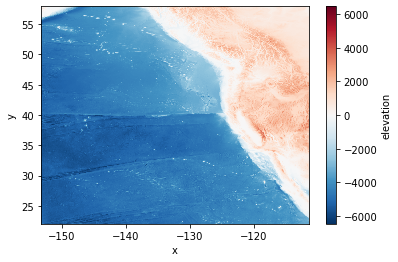

In [12]:
# isolate area for example

dr = gebco['elevation']
dr.plot()

In [9]:
# try xesmf

import xesmf as xe

regridder = xe.Regridder(gebco, grid, 'bilinear')
dr_out = regridder(dr)

Create weight file: bilinear_861x1004_61x41.nc


/Users/james/opt/anaconda3/envs/xgcm/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [10]:
dr_out

<xarray.DataArray 'elevation' (y: 61, x: 41)>
array([[    0.        , -4839.70237861, -4771.74436998, ...,
          252.02770105,   736.56893446,     0.        ],
       [-4696.93513106, -4898.40875123, -4731.33217062, ...,
           49.58532862,   260.61001863,   596.15390965],
       [-4765.31876075, -4676.81633572, -4573.51177629, ...,
           48.61594844,   399.18285347,   815.78554202],
       ...,
       [-5310.26071436, -5198.35366491, -5195.82453323, ...,
         1391.66983862,  1115.93119307,  1512.57048666],
       [-5252.08794739, -5242.26579012, -5226.17655778, ...,
         1622.54810485,  1384.62061532,  1802.61068373],
       [    0.        , -5251.9520842 , -5207.79673499, ...,
         1814.92321475,  1823.61840739,     0.        ]])
Coordinates:
    lon      (y, x) float64 -131.0 -130.5 -130.1 -129.6 ... -129.8 -129.1 -128.3
    lat      (y, x) float64 22.06 22.31 22.56 22.81 ... 57.19 57.44 57.69 57.93
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

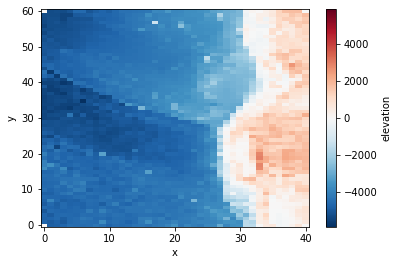

In [11]:
dr_out.plot()